In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import roc_auc_score
import datetime
import warnings
warnings.filterwarnings('ignore')

## 构造数据

In [6]:
data = pd.read_csv('train.txt')
train_set, test_set = train_test_split(data, test_size=0.2, random_state=2020)

train_label = train_set['label']
del train_set['label']
test_label = test_set['label']
del test_set['label']
data_df = pd.concat((train_set, test_set))


sparse_feas = [col for col in data_df.columns if col[0] == 'C']
dense_feas = [col for col in data_df.columns if col[0] == 'I']

data_df[sparse_feas] = data_df[sparse_feas].fillna('-1')
data_df[dense_feas] = data_df[dense_feas].fillna(0)

def sparseFeature(feat, feat_num, embed_dim=4):
    return {'feat':feat, 'feat_num':feat_num, 'embed_dim':embed_dim}
def denseFeature(feat):
    return {'feat':feat}
embed_dim = 8
feature_columns = [[denseFeature(feat) for feat in dense_feas]] + [[sparseFeature(feat, len(data_df[feat].unique()), embed_dim=embed_dim) for feat in sparse_feas]]

for feat in sparse_feas:
    le = LabelEncoder()
    data_df[feat] = le.fit_transform(data_df[feat])

mms = MinMaxScaler()
data_df[dense_feas] = mms.fit_transform(data_df[dense_feas])

train = data_df[:train_set.shape[0]]
test = data_df[train_set.shape[0]:]

train['label'] = train_label
test['label'] = test_label

train_set, val_set = train_test_split(train, test_size=0.1, random_state=2020)

train_set.reset_index(drop=True, inplace=True)
val_set.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
print(feature_columns)
print(train_set.shape, val_set.shape, test.shape)

[[{'feat': 'I1'}, {'feat': 'I2'}, {'feat': 'I3'}, {'feat': 'I4'}, {'feat': 'I5'}, {'feat': 'I6'}, {'feat': 'I7'}, {'feat': 'I8'}, {'feat': 'I9'}, {'feat': 'I10'}, {'feat': 'I11'}, {'feat': 'I12'}, {'feat': 'I13'}], [{'feat': 'C1', 'feat_num': 79, 'embed_dim': 8}, {'feat': 'C2', 'feat_num': 252, 'embed_dim': 8}, {'feat': 'C3', 'feat_num': 1293, 'embed_dim': 8}, {'feat': 'C4', 'feat_num': 1043, 'embed_dim': 8}, {'feat': 'C5', 'feat_num': 30, 'embed_dim': 8}, {'feat': 'C6', 'feat_num': 7, 'embed_dim': 8}, {'feat': 'C7', 'feat_num': 1164, 'embed_dim': 8}, {'feat': 'C8', 'feat_num': 39, 'embed_dim': 8}, {'feat': 'C9', 'feat_num': 2, 'embed_dim': 8}, {'feat': 'C10', 'feat_num': 908, 'embed_dim': 8}, {'feat': 'C11', 'feat_num': 926, 'embed_dim': 8}, {'feat': 'C12', 'feat_num': 1239, 'embed_dim': 8}, {'feat': 'C13', 'feat_num': 824, 'embed_dim': 8}, {'feat': 'C14', 'feat_num': 20, 'embed_dim': 8}, {'feat': 'C15', 'feat_num': 819, 'embed_dim': 8}, {'feat': 'C16', 'feat_num': 1159, 'embed_dim': 

In [8]:
trn_x = train_set.drop('label', axis=1).values
trn_y = train_set['label'].values
val_x = val_set.drop('label', axis=1).values
val_y = val_set['label'].values
dl_train_dataset = TensorDataset(torch.tensor(trn_x).float(), torch.tensor(trn_y).float())
dl_val_dataset = TensorDataset(torch.tensor(val_x).float(), torch.tensor(val_y).float())

dl_train = DataLoader(dl_train_dataset, shuffle=True, batch_size=32)
dl_val = DataLoader(dl_val_dataset, shuffle=True, batch_size=32)

#看下数据
for b in iter(dl_train):
    print(b[0].shape, b[1])
    break

torch.Size([32, 39]) tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.])


## 构建模型

In [18]:
class Linear(nn.Module):
    def __init__(self, input_dim):
        super(Linear, self).__init__()
        self.linear = nn.Linear(in_features=input_dim, out_features=1)
    def forward(self, x):
        return self.linear(x)

class Dnn(nn.Module):
    def __init__(self, hidden_units, dropout=0.):
        super(Dnn, self).__init__()
        self.dnn_network = nn.ModuleList([nn.Linear(layer[0], layer[1]) for layer in list(zip(hidden_units[:-1], hidden_units[1:]))])
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        for linear in self.dnn_network:
            x = linear(x)
            x = F.relu(x)
        x = self.dropout(x)
        return x

class WideDeep(nn.Module):
    def __init__(self, feature_columns, hidden_units, dnn_dropout=0.):
        super(WideDeep, self).__init__()
        self.dense_feature_cols, self.sparse_feature_cols = feature_columns
        
        #embedding
        self.embed_layers = nn.ModuleDict({
            'embed_' + str(i):nn.Embedding(num_embeddings=feat['feat_num'], embedding_dim=feat['embed_dim']) for i, feat in enumerate(self.sparse_feature_cols)
        })
        hidden_units.insert(0, len(self.dense_feature_cols) + len(self.sparse_feature_cols) * self.sparse_feature_cols[0]['embed_dim'])
        self.dnn_network = Dnn(hidden_units)
        self.linear = Linear(len(self.dense_feature_cols))
        self.final_linear = nn.Linear(hidden_units[-1], 1)
    def forward(self, x):
        dense_input, sparse_inputs = x[:, :len(self.dense_feature_cols)], x[:, len(self.dense_feature_cols):]
        sparse_inputs = sparse_inputs.long()
        sparse_embeds = [self.embed_layers['embed_'+str(i)](sparse_inputs[:,i]) for i in range(sparse_inputs.shape[1])]
        sparse_embeds = torch.cat(sparse_embeds, -1)
        
        dnn_input = torch.cat([sparse_embeds, dense_input], -1)
        
        #Wide部分
        wide_out = self.linear(dense_input)
        
        #Deep部分
        deep_out = self.dnn_network(dnn_input)
        deep_out = self.final_linear(deep_out)
        
        #out
        outputs = F.sigmoid(0.5 * (wide_out + deep_out))
        return outputs

In [19]:
#建立模型
hidden_units = [256, 128, 64]
dnn_dropout = 0.

model = WideDeep(feature_columns, hidden_units, dnn_dropout)
model

WideDeep(
  (embed_layers): ModuleDict(
    (embed_0): Embedding(79, 8)
    (embed_1): Embedding(252, 8)
    (embed_10): Embedding(926, 8)
    (embed_11): Embedding(1239, 8)
    (embed_12): Embedding(824, 8)
    (embed_13): Embedding(20, 8)
    (embed_14): Embedding(819, 8)
    (embed_15): Embedding(1159, 8)
    (embed_16): Embedding(9, 8)
    (embed_17): Embedding(534, 8)
    (embed_18): Embedding(201, 8)
    (embed_19): Embedding(4, 8)
    (embed_2): Embedding(1293, 8)
    (embed_20): Embedding(1204, 8)
    (embed_21): Embedding(7, 8)
    (embed_22): Embedding(12, 8)
    (embed_23): Embedding(729, 8)
    (embed_24): Embedding(33, 8)
    (embed_25): Embedding(554, 8)
    (embed_3): Embedding(1043, 8)
    (embed_4): Embedding(30, 8)
    (embed_5): Embedding(7, 8)
    (embed_6): Embedding(1164, 8)
    (embed_7): Embedding(39, 8)
    (embed_8): Embedding(2, 8)
    (embed_9): Embedding(908, 8)
  )
  (dnn_network): Dnn(
    (dnn_network): ModuleList(
      (0): Linear(in_features=221, out_

In [20]:
#测试一下模型
for fea, label in iter(dl_train):
    out = model(fea)
    print(out)
    break

tensor([[0.5291],
        [0.5258],
        [0.5251],
        [0.5245],
        [0.5226],
        [0.5185],
        [0.5237],
        [0.5180],
        [0.5267],
        [0.5198],
        [0.5232],
        [0.5186],
        [0.5170],
        [0.5010],
        [0.5210],
        [0.5185],
        [0.5251],
        [0.5231],
        [0.5252],
        [0.5192],
        [0.5157],
        [0.5272],
        [0.5239],
        [0.5171],
        [0.5280],
        [0.5249],
        [0.5233],
        [0.5176],
        [0.5266],
        [0.5184],
        [0.5222],
        [0.5222]], grad_fn=<SigmoidBackward>)


## 模型的训练

In [21]:
def auc(y_pred, y_true):
    pred = y_pred.data
    y = y_true.data
    return roc_auc_score(y, pred)

loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
metric_func = auc
metric_name = 'auc'

In [22]:
epochs = 10
log_step_freq = 10

dfhistory = pd.DataFrame(columns=['epoch', 'loss', metric_name, 'val_loss', 'val_'+metric_name])

print('start_training.........')
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('========'*8 + '%s' %nowtime)

for epoch in range(1, epochs+1):
    
    # 训练阶段
    model.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1
    
    for step, (features, labels) in enumerate(dl_train, 1):
        # 梯度清零
        optimizer.zero_grad()
        
        # 正向传播
        predictions = model(features);
        loss = loss_func(predictions, labels)
        try:
            metric = metric_func(predictions, labels)
        except ValueError:
            pass
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        # 打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step % log_step_freq == 0:
            print(("[step=%d] loss: %.3f, " + metric_name + ": %.3f") % (step, loss_sum/step, metric_sum/step));
    
    # 验证阶段
    model.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1
    
    for val_step, (features, labels) in enumerate(dl_val, 1):
        with torch.no_grad():
            predictions = model(features)
            val_loss = loss_func(predictions, labels)
            try:
                val_metric = metric_func(predictions, labels)
            except ValueError:
                pass
        
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()
    
    # 记录日志
    info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info
    
    # 打印日志
    print(("\nEPOCH=%d, loss=%.3f, " + metric_name + " = %.3f, val_loss=%.3f, " + "val_" + metric_name + " = %.3f") %info)
    nowtime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print('\n' + '=========='* 8 + '%s' %nowtime)
    
print('Finished Training')

start_training.........
================================================================2022-08-02 14:45:35
[step=10] loss: 0.616, auc: 0.558
[step=20] loss: 0.573, auc: 0.563
[step=30] loss: 0.552, auc: 0.581
[step=40] loss: 0.533, auc: 0.560

EPOCH=1, loss=0.530, auc = 0.560, val_loss=0.590, val_auc = 0.696

================================================================================2022-08-02 14:45:36
[step=10] loss: 0.503, auc: 0.774
[step=20] loss: 0.480, auc: 0.787
[step=30] loss: 0.450, auc: 0.773
[step=40] loss: 0.444, auc: 0.767

EPOCH=2, loss=0.441, auc = 0.759, val_loss=0.569, val_auc = 0.718

================================================================================2022-08-02 14:45:36
[step=10] loss: 0.363, auc: 0.878
[step=20] loss: 0.371, auc: 0.848
[step=30] loss: 0.379, auc: 0.849
[step=40] loss: 0.386, auc: 0.838

EPOCH=3, loss=0.391, auc = 0.840, val_loss=0.550, val_auc = 0.713

================================================================================

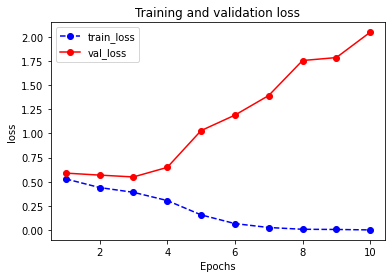

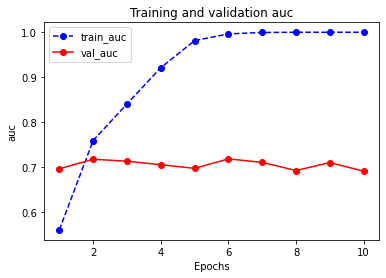

In [25]:
import matplotlib.pyplot as plt
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()


# 观察损失和准确率的变化,看loss 可以看到过拟合
plot_metric(dfhistory,"loss")
plot_metric(dfhistory,"auc")

In [30]:
# 预测
from sklearn.metrics import accuracy_score
test_x = test.drop('label', axis=1).values
test_y = test['label'].values
y_pred_probs = model(torch.tensor(test_x).float())
y_pred = torch.where(y_pred_probs>0.5, torch.ones_like(y_pred_probs), torch.zeros_like(y_pred_probs))

test_auc = roc_auc_score(test_y, y_pred_probs.data.numpy())
test_acc = accuracy_score(test_y, y_pred.data.numpy())
print('test_auc:%.3f test_acc:%.3f'%(test_auc, test_acc))

test_auc:0.656 test_acc:0.750
